In [1]:
from warnings import filterwarnings
from anndata import ImplicitModificationWarning
from matplotlib import MatplotlibDeprecationWarning
from numba import NumbaDeprecationWarning

filterwarnings('ignore', category=ImplicitModificationWarning)
filterwarnings('ignore', category=MatplotlibDeprecationWarning)
filterwarnings('ignore', category=NumbaDeprecationWarning)

from FlowCytometryTools import FCPlate
from utils.gates import GatingSchema

from progressbar import ProgressBar
from re import search
from glob import glob
from os.path import join

from pandas import DataFrame,Index,Series
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn import mixture
from scipy.signal import argrelextrema

from numpy import array,nan,isnan,arcsinh,unique,mean,dot,argmin,argmax,std,einsum,eye,linspace,amin,amax,exp,less,gradient,abs
from numpy.random import choice

from scanpy import AnnData,settings,logging,settings
from scanpy.preprocessing import neighbors
from scanpy.tools import umap,leiden

from scanpy.plotting import stacked_violin
from scanpy.plotting import umap as plot_umap
from scanpy.plotting._tools.scatterplots import _get_data_points

from matplotlib.collections import PolyCollection
from matplotlib.pyplot import hist,plot,title,figure,subplot,figlegend,xticks,yticks,axis,xticks,yticks,axhline
from matplotlib.pyplot import axvline,matshow,xlabel,ylabel,ylim,xlim,tight_layout,yscale,fill_between,setp
from seaborn import swarmplot,boxplot,violinplot

settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
settings.set_figure_params(dpi=80, facecolor='white')

################################################# helper functions
def parser(file_path) :
    
    tissue = search('_(.+?)_',file_path).group()
    if 'Blood' in tissue : tissue = '_Blood_'
    patient = search('/[0-9]+C/',file_path).group()

    return (tissue[1:-1],patient[1:-1])

################################################## estimate cutoffs between bimodal populations
def estimate_cutoffs(data) :
    cutoffs = []
    
    for i,channel in enumerate(data.X.T) :
        X = channel.reshape(-1, 1)
        
        gmm = mixture.BayesianGaussianMixture(
            n_components=3, covariance_type='spherical',

            weight_concentration_prior=1e-2,
            mean_precision_prior=1e-2,

            covariance_prior= array([5.0]),
            mean_prior= array([0.0]),

            max_iter=5000,
            tol=2e-2

        ).fit(X)
        
        x = linspace(amin(channel),amax(channel),100)
        px = exp(gmm.score_samples(x.reshape(-1, 1)))
        
        min_index, = argrelextrema(px,less)
        xminima = x[min_index]
        pminima = px[min_index]
        
        if len(xminima)>0 :
            cutoff = xminima[0]

        else : # fwhm
            min_index, = argrelextrema(abs(px-amax(px)/4),less)
            left,right = x[min_index]
            cutoff = right
            
            if sum(px[x<cutoff]*x[x<cutoff])/sum(px[x<cutoff]) > 3.0 :
                cutoff = left

        cutoffs.append(cutoff)
    return array(cutoffs)

In [2]:
################################################# define order of observations
patients = [ '390C', '423C', '428C', '412C', '403C' ]
tissues = [ 'Blood','Spleen','tLN','mLN','BM','Ileum','Lung','Liver']
markers = [
    'CD3','CD8','CD4','CD45RA','CCR7',      #top-level
    'CXCR3','CCR6','CCR4','CCR10','CXCR5',  #helper
    'CD127','CD25','Foxp3','Helios',        #regulatory
    'PD-1','CD69','CD103','HLA-DR'          #state
]

################################################# load fcs files
plate = FCPlate.from_dir(
    ID='TissueAtlas', path='./data/*/',  pattern='*.cleaned.fcs',
    
    parser=parser, position_mapper= lambda x: x,
    row_labels=tissues,col_labels=patients)

################################################ load labels
labels = {}
for idx in plate :

    tissue,patient = idx
    label_path = glob(join('data',patient,'*_'+tissue+'_*.xml'))

    if len(label_path) > 0 :
        labels[idx] = GatingSchema(*label_path).get_labels(plate[idx])
    else :
        labels[idx] = Series( {'label':None}, index=plate[idx].data.index, dtype='string')

In [3]:
############################################### standardise channel names
channel_map = {
    'Foxp3-IgM': 'Foxp3', 
    'FJComp-355 379_28-A': 'CD3', 
    'FJComp-355 560_40-A': 'CD8', 
    'FJComp-355 740_35-A': 'CD69', 
    'FJComp-355 820_60-A': 'CD4', 
    'FJComp-405 450_50-A': 'CD103', 
    'FJComp-405 515_20-A': 'HLA-DR', 
    'FJComp-405 605_40-A': 'CCR4', 
    'FJComp-405 670_30-A': 'CCR6', 
    'FJComp-405 710_40-A': 'PD-1', 
    'FJComp-405 780_60-A': 'CD45RA', 
    'FJComp-488 525_50-A': 'CCR10', 
    'FJComp-488 715_30-A': 'CXCR3', 
    'FJComp-561 585_15-A': 'Foxp3', 
    'FJComp-561 610_20-A': 'Helios', 
    'FJComp-561 780_60-A': 'CD127', 
    'FJComp-640 670_30-A': 'CD25', 
    'FJComp-640 730_35-A': 'CXCR5', 
    'FJComp-640 780_60-A': 'CCR7'
}

for idx in plate :
    
    plate[idx].data = plate[idx].data.rename(columns=channel_map)
    plate[idx].data = plate[idx].data.reindex(columns=markers)
    plate[idx].meta['_channel_names_'] = tuple(markers)

################################################# apply biexponential transfromation
cofactor = 250.0
dataset = plate.transform( lambda x: arcsinh(x/cofactor) )

################################################# convert plate into scanpy object
others = []
bar = ProgressBar(maxval=len(plate)).start()
for i,idx in enumerate(plate) :

    ################################################# uniform subsample of data
    sample_size,subsample = len(dataset[idx].data), 10000
    if subsample < sample_size :

        choices = choice(range(sample_size),size=subsample,replace=False)
        mask = array([ index in choices for index in dataset[idx].data.index ])
        subset = dataset[idx].data[mask].reset_index().drop(columns=['index'])

    else :
        subset = dataset[idx].data.reset_index().drop(columns=['index'])

    ################################################# convert to AnnData
    observations = DataFrame(index=subset.index, columns=['tissue','patient'])
    observations['tissue'],observations['patient'] = idx
    observations['labels'] = labels[idx]

    antigen = DataFrame(index=Index(subset.columns,name='index'), columns=['type']); antigen['type'] = None
    annotated_data = AnnData(subset,obs=observations,var=antigen)

    ################################################# batch normalisation
    annotated_data.X -= estimate_cutoffs(annotated_data)
    
    for j,channel in enumerate(annotated_data.X.T) :
        mask = channel>0

        annotated_data.X[mask,j] /= mean(channel[mask])
        annotated_data.X[~mask,j] /= -mean(channel[~mask])
    
    if i == 1 :
        first = annotated_data
    else :
        others += [annotated_data]
    bar.update(i)

annotated_dataset = first.concatenate(others)
bar.update(i+1)

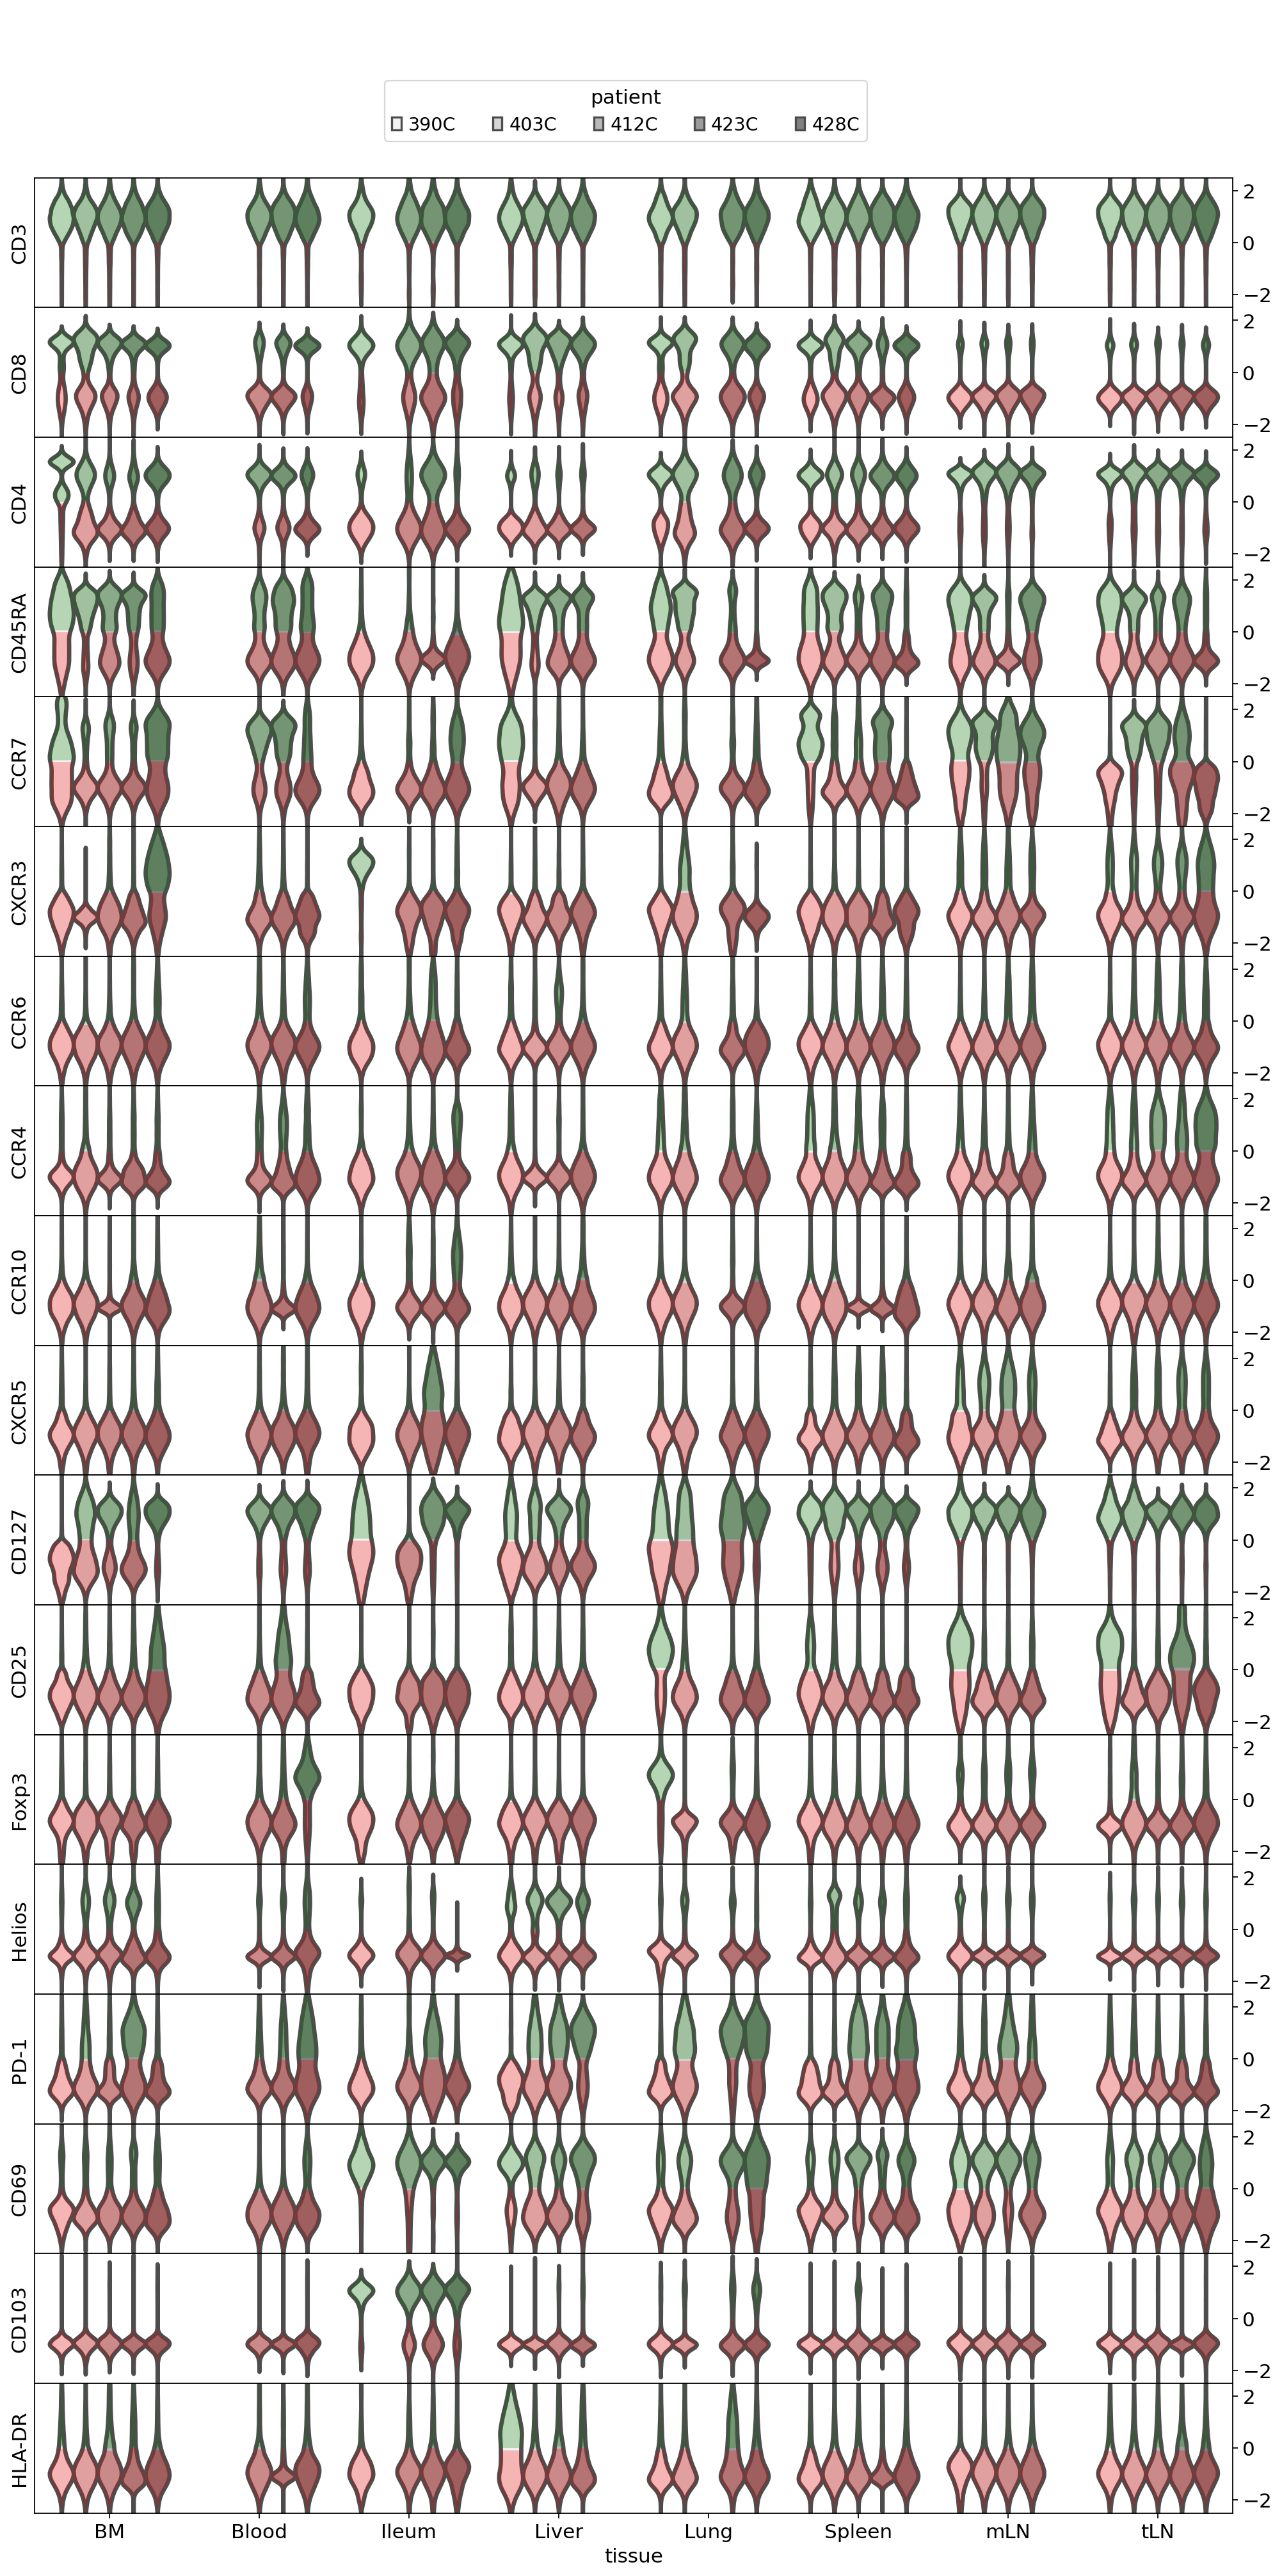

In [36]:
fig = figure(figsize=(15,30))
data = annotated_dataset.obs.join(
    DataFrame(annotated_dataset.X, index=annotated_dataset.obs.index,
              columns=annotated_dataset.var.index))

n_channels = len(annotated_dataset.var.index)
for i,channel in enumerate(annotated_dataset.var.index) :
    ax = subplot(n_channels,1,i+1)
    
    violinplot(x='tissue', y=channel, hue='patient', data=data,
               scale='width',inner=None, color='gray',linewidth=3)
    
    for element in ax.get_children():
        if isinstance(element,PolyCollection):
            path, = element.get_paths()
            
            vertices = path.vertices[path.vertices[:,1]>0]
            ax.add_collection(PolyCollection(vertices[None,...],facecolor='green',alpha=0.25))
            
            vertices = path.vertices[path.vertices[:,1]<0]
            ax.add_collection(PolyCollection(vertices[None,...],facecolor='red',alpha=0.25))
    
    ax.yaxis.tick_right()
    ylim(-2.5,2.5)
    
    handles,labels = ax.get_legend_handles_labels()
    ax.grid(False)

fig.subplots_adjust(hspace=0)
ax.get_shared_x_axes().join(*fig.axes)

setp([ ax.get_xticklabels() for ax in fig.axes[:-1]], visible=False)
[ ax.get_legend().remove() for ax in fig.axes ]
fig.legend(handles, labels, loc = (0.300,0.945), ncol=5, title='patient')

In [5]:
################################################# dimensionality reduction
neighbors(annotated_dataset, n_neighbors=10, n_pcs=40)
umap(annotated_dataset)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:39)


In [ ]:
fig = plot_umap(annotated_dataset, color=markers, ncols=5, return_fig=True,
                color_map='RdYlGn',vmin=-1.5,vmax=1.5)

for ax in fig.axes :
    
    ax.set_xlabel('')
    ax.set_ylabel('')

    if ax.collections[0].colorbar != None :
        ax.collections[0].colorbar.remove()

fig.colorbar(fig.axes[0].collections[0], ax=fig.axes, shrink=0.95)
fig.set_size_inches((18,10))

In [92]:
################################################# clustering
leiden(annotated_dataset)

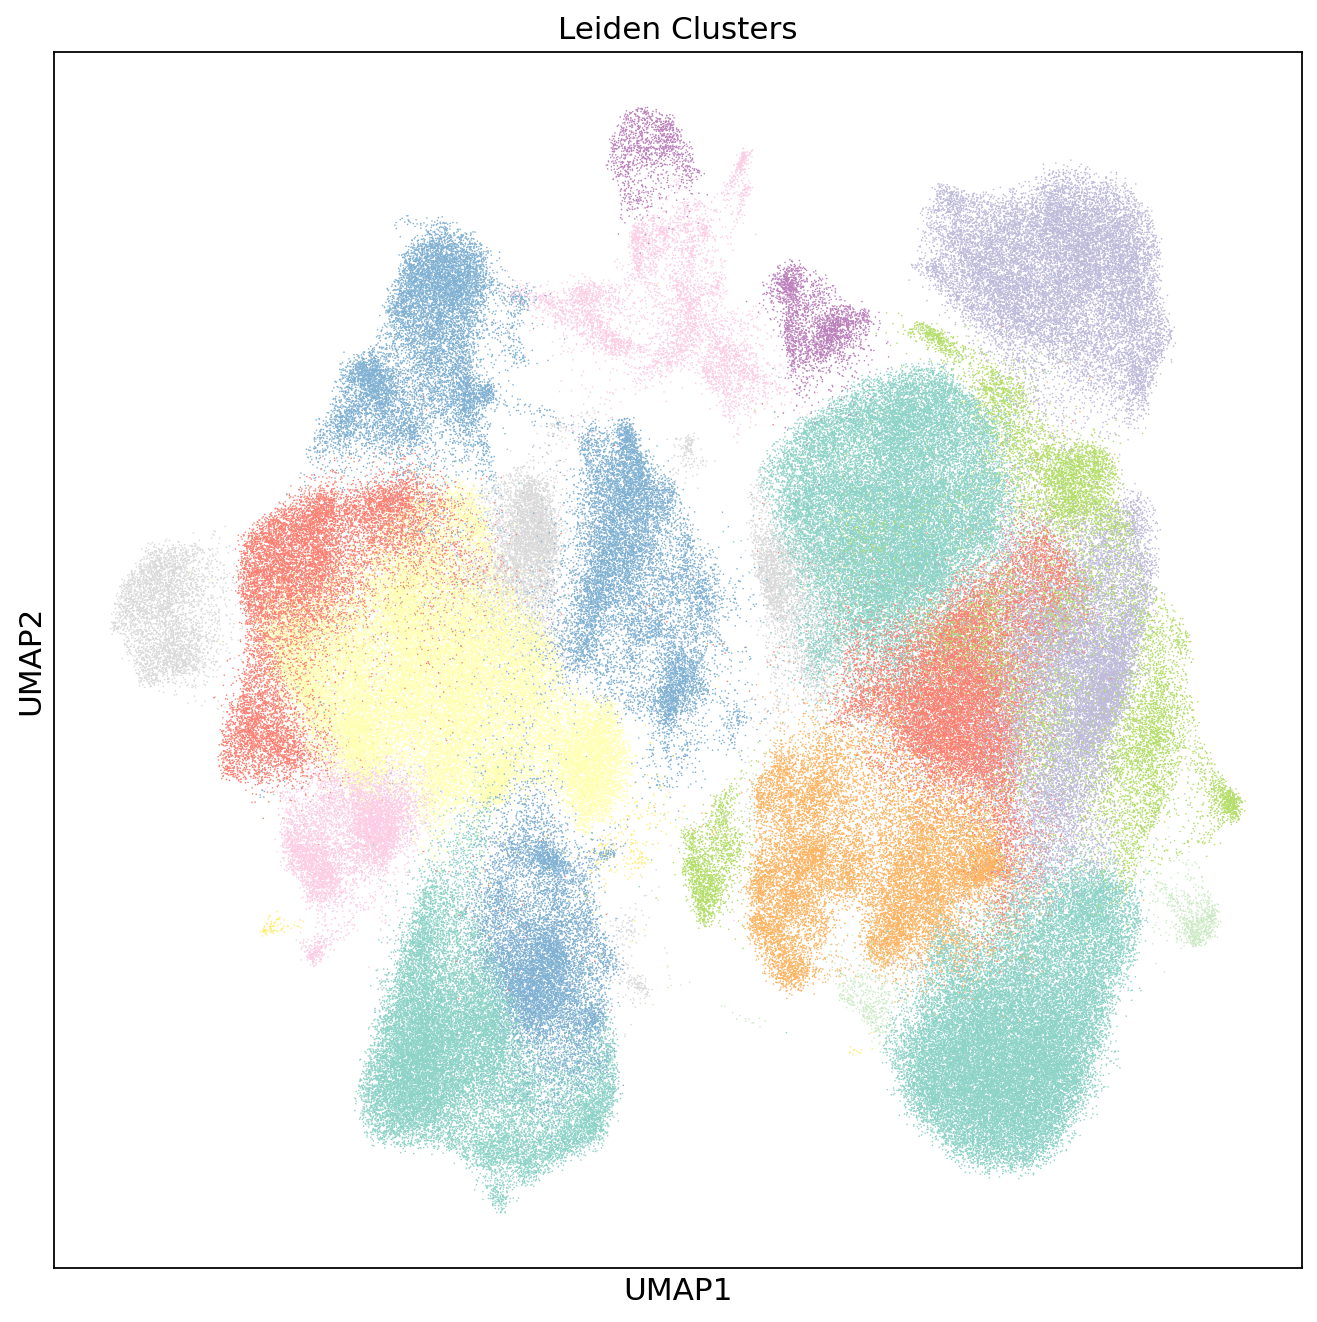

In [98]:
fig = plot_umap(annotated_dataset, color='leiden', title='Leiden Clusters',
                palette='Set3',return_fig=True, size=2)

ax = fig.axes[0].get_legend().remove()
fig.set_size_inches((10,10))

In [8]:
%%capture
violins = stacked_violin(annotated_dataset, markers, groupby='leiden',
    figsize=(15,20), swap_axes=True, scale='area', dendrogram=True);

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


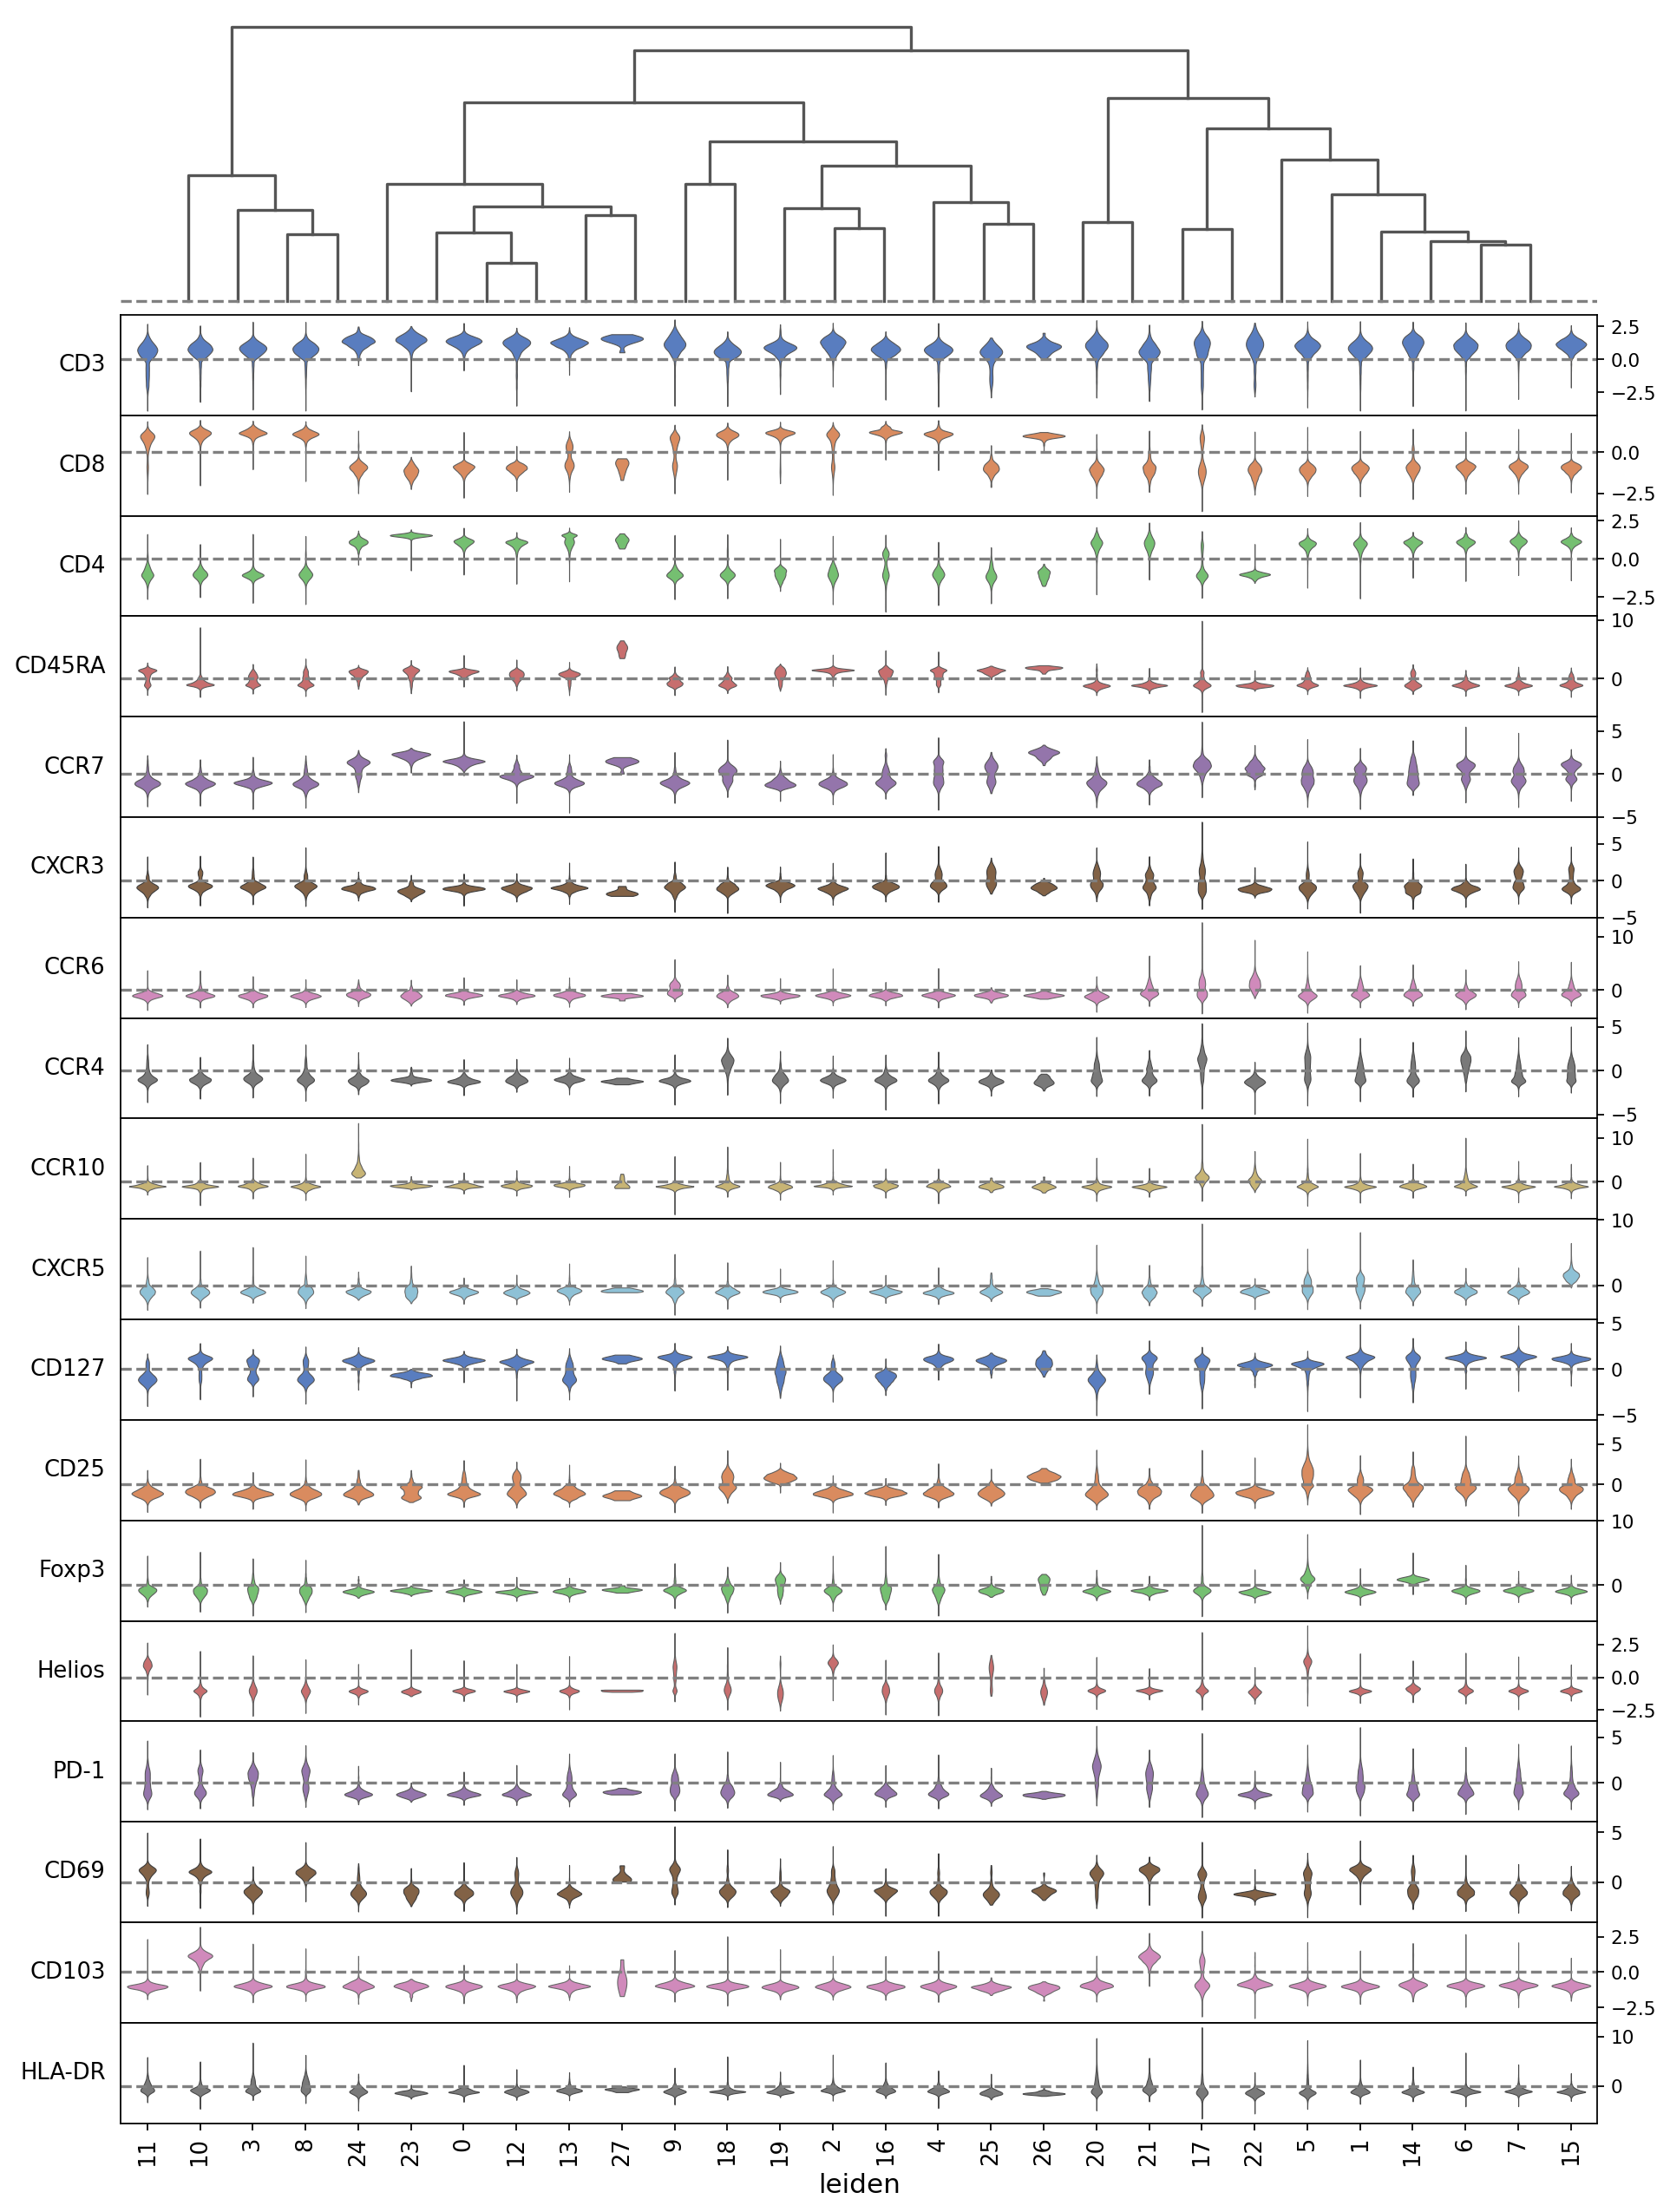

In [9]:
for ax in violins:
    ax.axhline(0,color='gray',linestyle='--')
violins[0].figure

/home/gszep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


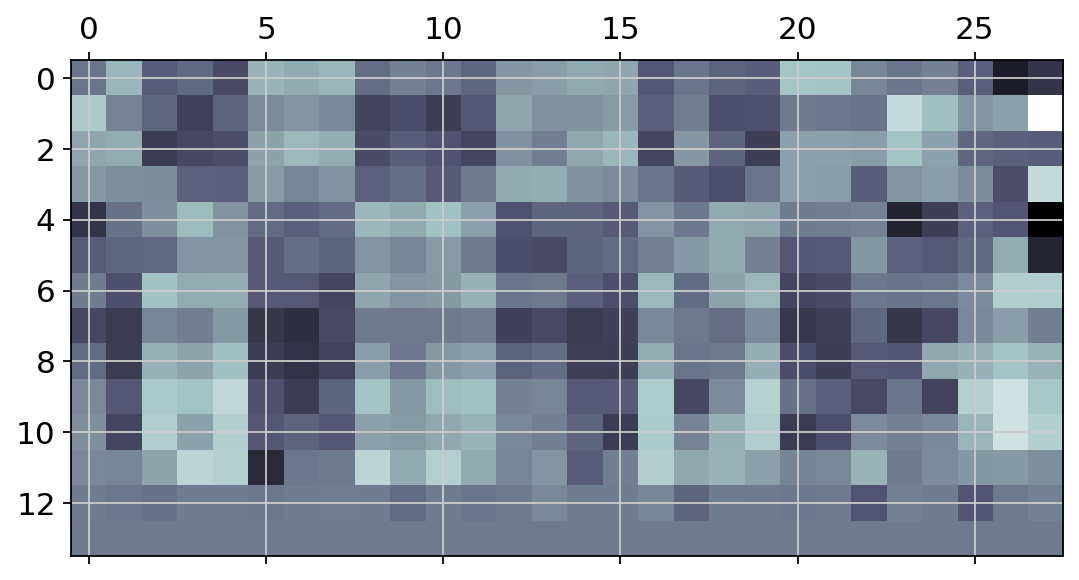

In [10]:
profile_names = [
    'CD8+|Naive','CD8+|EM','CD8+|EMRA','CD8+|CM',
    'CD4+|Naive','CD4+|EMRA',
    'CD4+|Th1','CD4+|Th2','CD4+|Th17','CD4+|Th22',
    'CD4+|Tfh','CD4+|Treg',
    'CD4-|CD8-','Unmatched'
]

profile_matrix = array([
    
    # CD3,CD8,CD4,CD45RA,CCR7    CXCR3,CCR6,CCR4,CCR10,CXCR5    CD127,CD25,Foxp3,Helios    PD-1,CD69,CD103,HLA-DR       
    [  0,  1, -1,   1,    1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD8+|Naive
    [  0,  1, -1,  -1,   -1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD8+|EM
    [  0,  1, -1,   1,   -1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD8+|EMRA
    [  0,  1, -1,  -1,    1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD8+|CM
    
    [  0, -1,  1,   1,    1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Naive
    [  0, -1,  1,   1,   -1,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|EMRA
    
    [  0, -1,  1,  -1,    0,       1,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Th1
    [  0, -1,  1,  -1,    0,      -1,   -1,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Th2
    [  0, -1,  1,  -1,    0,      -1,    1,   1,  -1,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Th17
    [  0, -1,  1,  -1,    0,      -1,    1,   1,   1,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4+|Th22

    [  0, -1,  1,  -1,    0,       0,    0,   0,   0,    1,       0,   0,    0,    0,        1,  0,    0,    0], # CD4+|Tfh
    [  0, -1,  1,   0,    0,       0,    0,   0,   0,    0,       0,   1,    1,    1,        0,  0,    0,    0], # CD4+|Treg

    [  0, -1, -1,   0,    0,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # CD4-|CD8-
    [  0,  0,  0,   0,    0,       0,    0,   0,   0,    0,       0,   0,    0,    0,        0,  0,    0,    0], # unmatched

])

def apply_labels(data, profile_matrix, profile_names, observation='label') :

    n_clusters = len(unique(data.obs.leiden.values))
    mapping_matrix = []

    for id in range(n_clusters):
        mapping_matrix += [mean(dot(data.X[data.obs.leiden == str(id)],profile_matrix.T),axis=0)]
        
    mapping_matrix = array(mapping_matrix).T
    matshow(mapping_matrix,cmap='bone_r')
    
    data.obs[observation] = 'Unmatched'
    for i,j in enumerate( argmax(mapping_matrix,axis=0)) :
        
        data.obs[observation][data.obs.leiden==str(i)] = profile_names[j]
        
apply_labels(annotated_dataset, profile_matrix, profile_names)
labels = annotated_dataset.obs.label.unique() 

In [11]:
%%capture
violins = stacked_violin(annotated_dataset, markers, groupby='label',
    figsize=(10,20), swap_axes=True, scale='area',dendrogram=True);

... storing 'label' as categorical


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_label']`


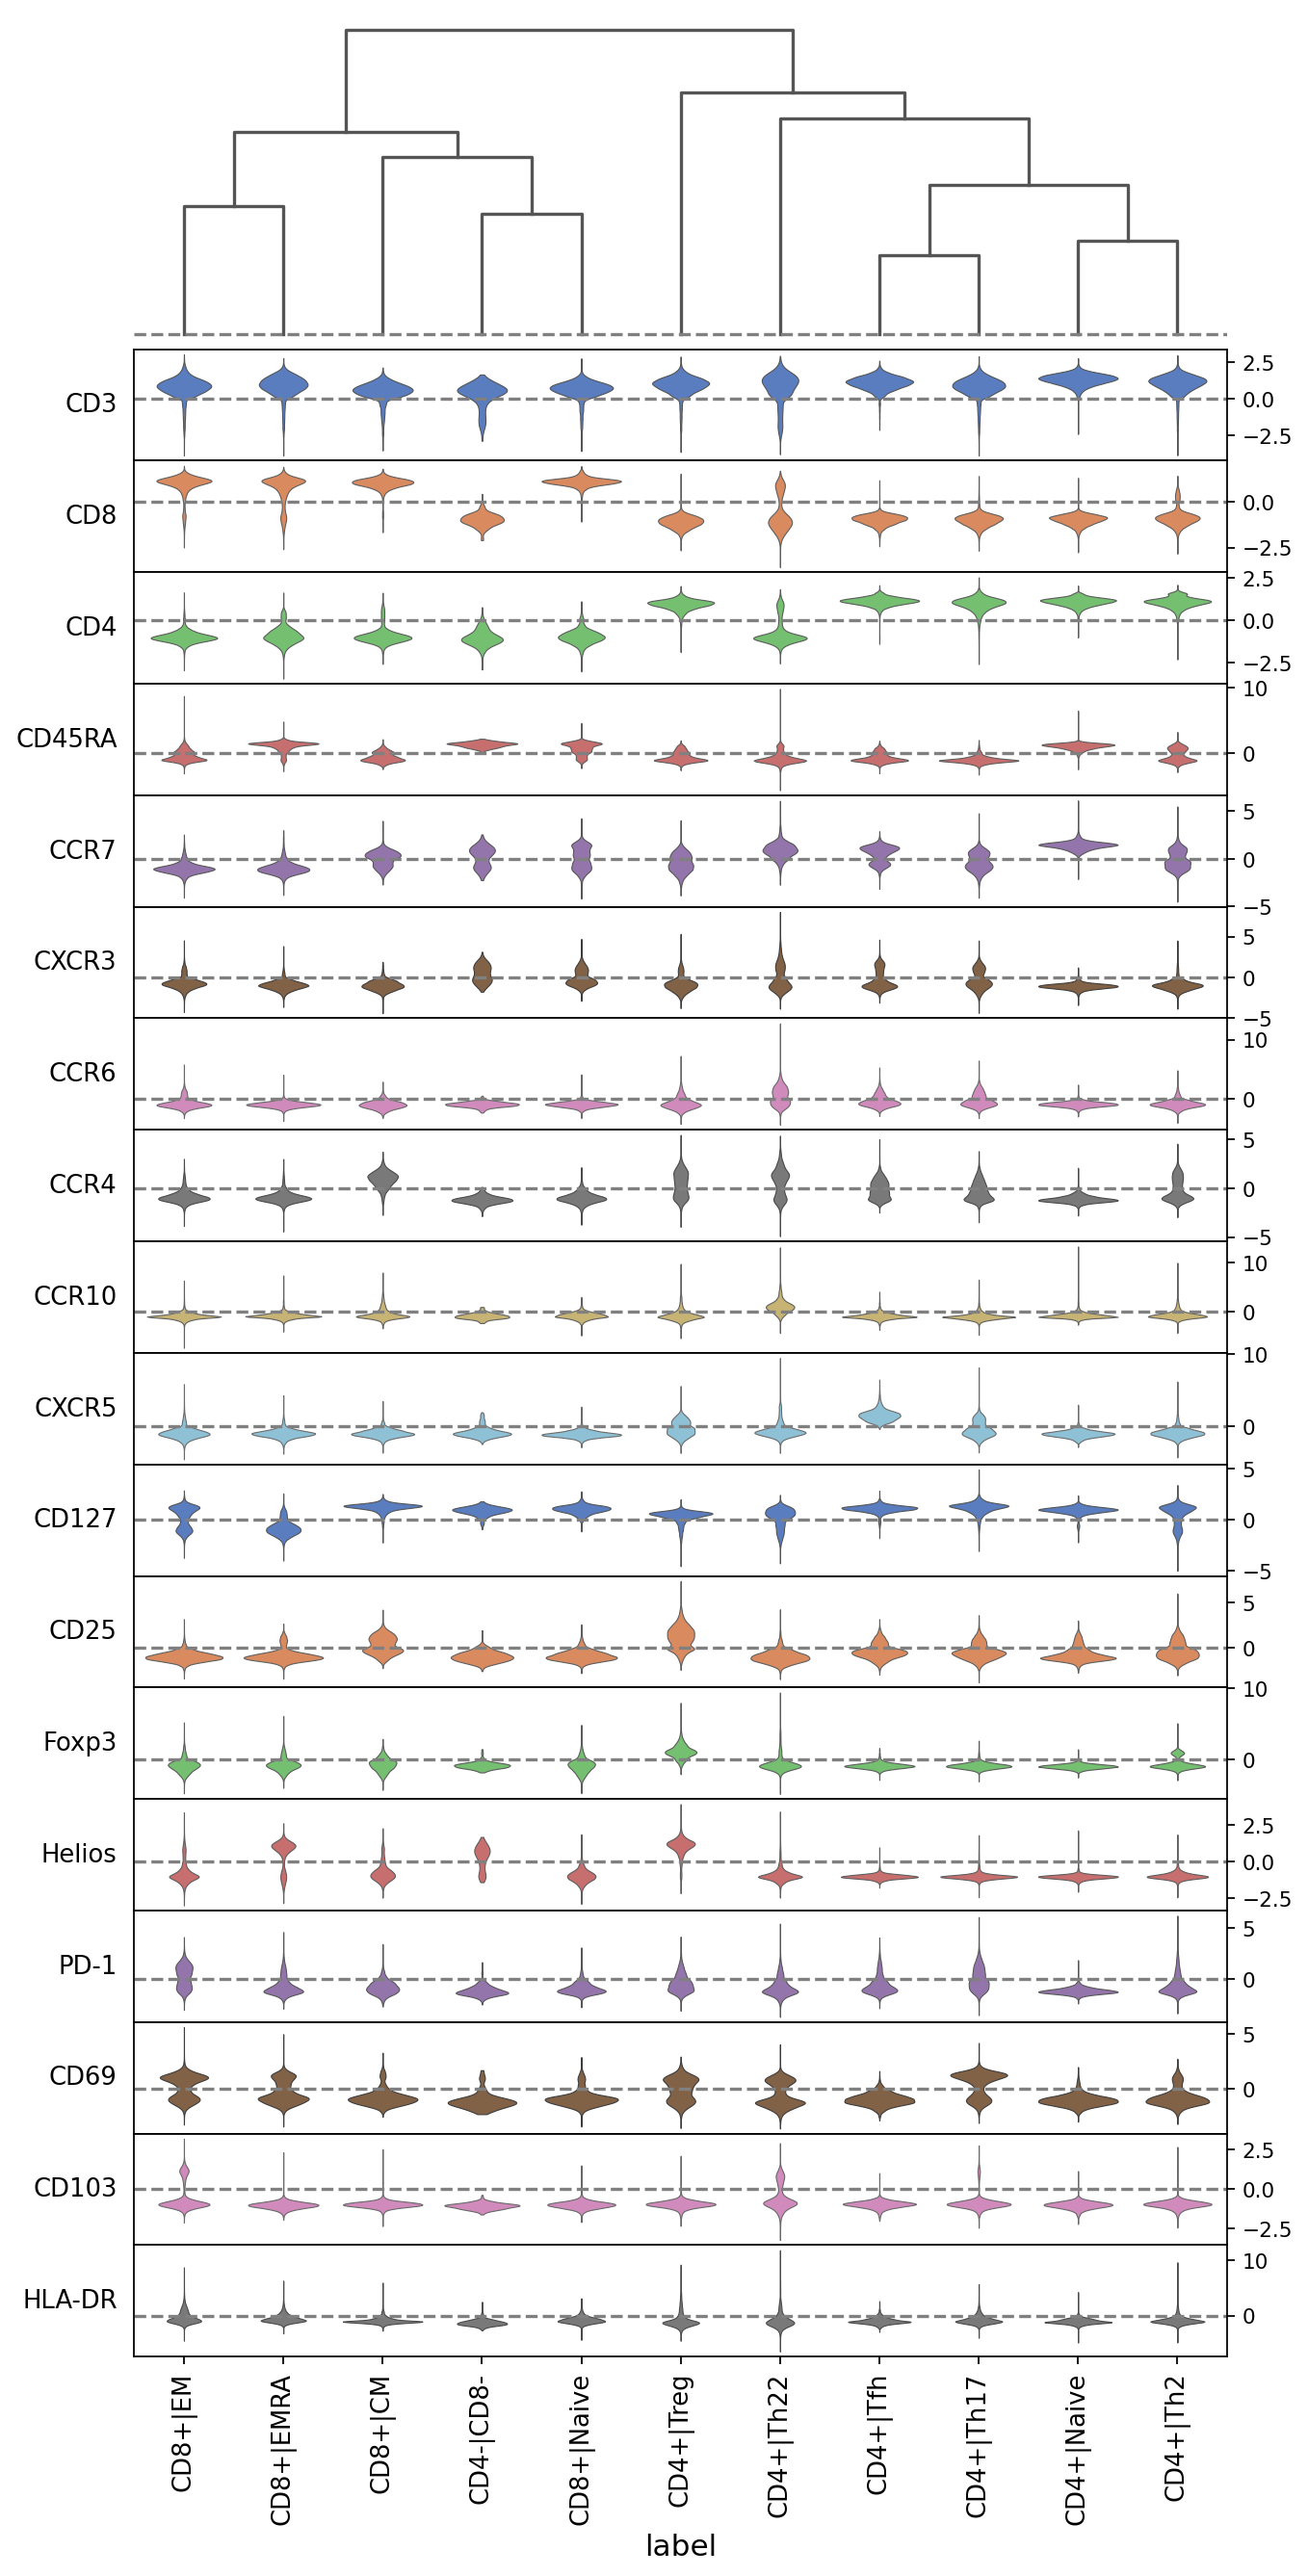

In [12]:
for ax in violins:
    ax.axhline(0,color='gray',linestyle='--')
violins[0].figure

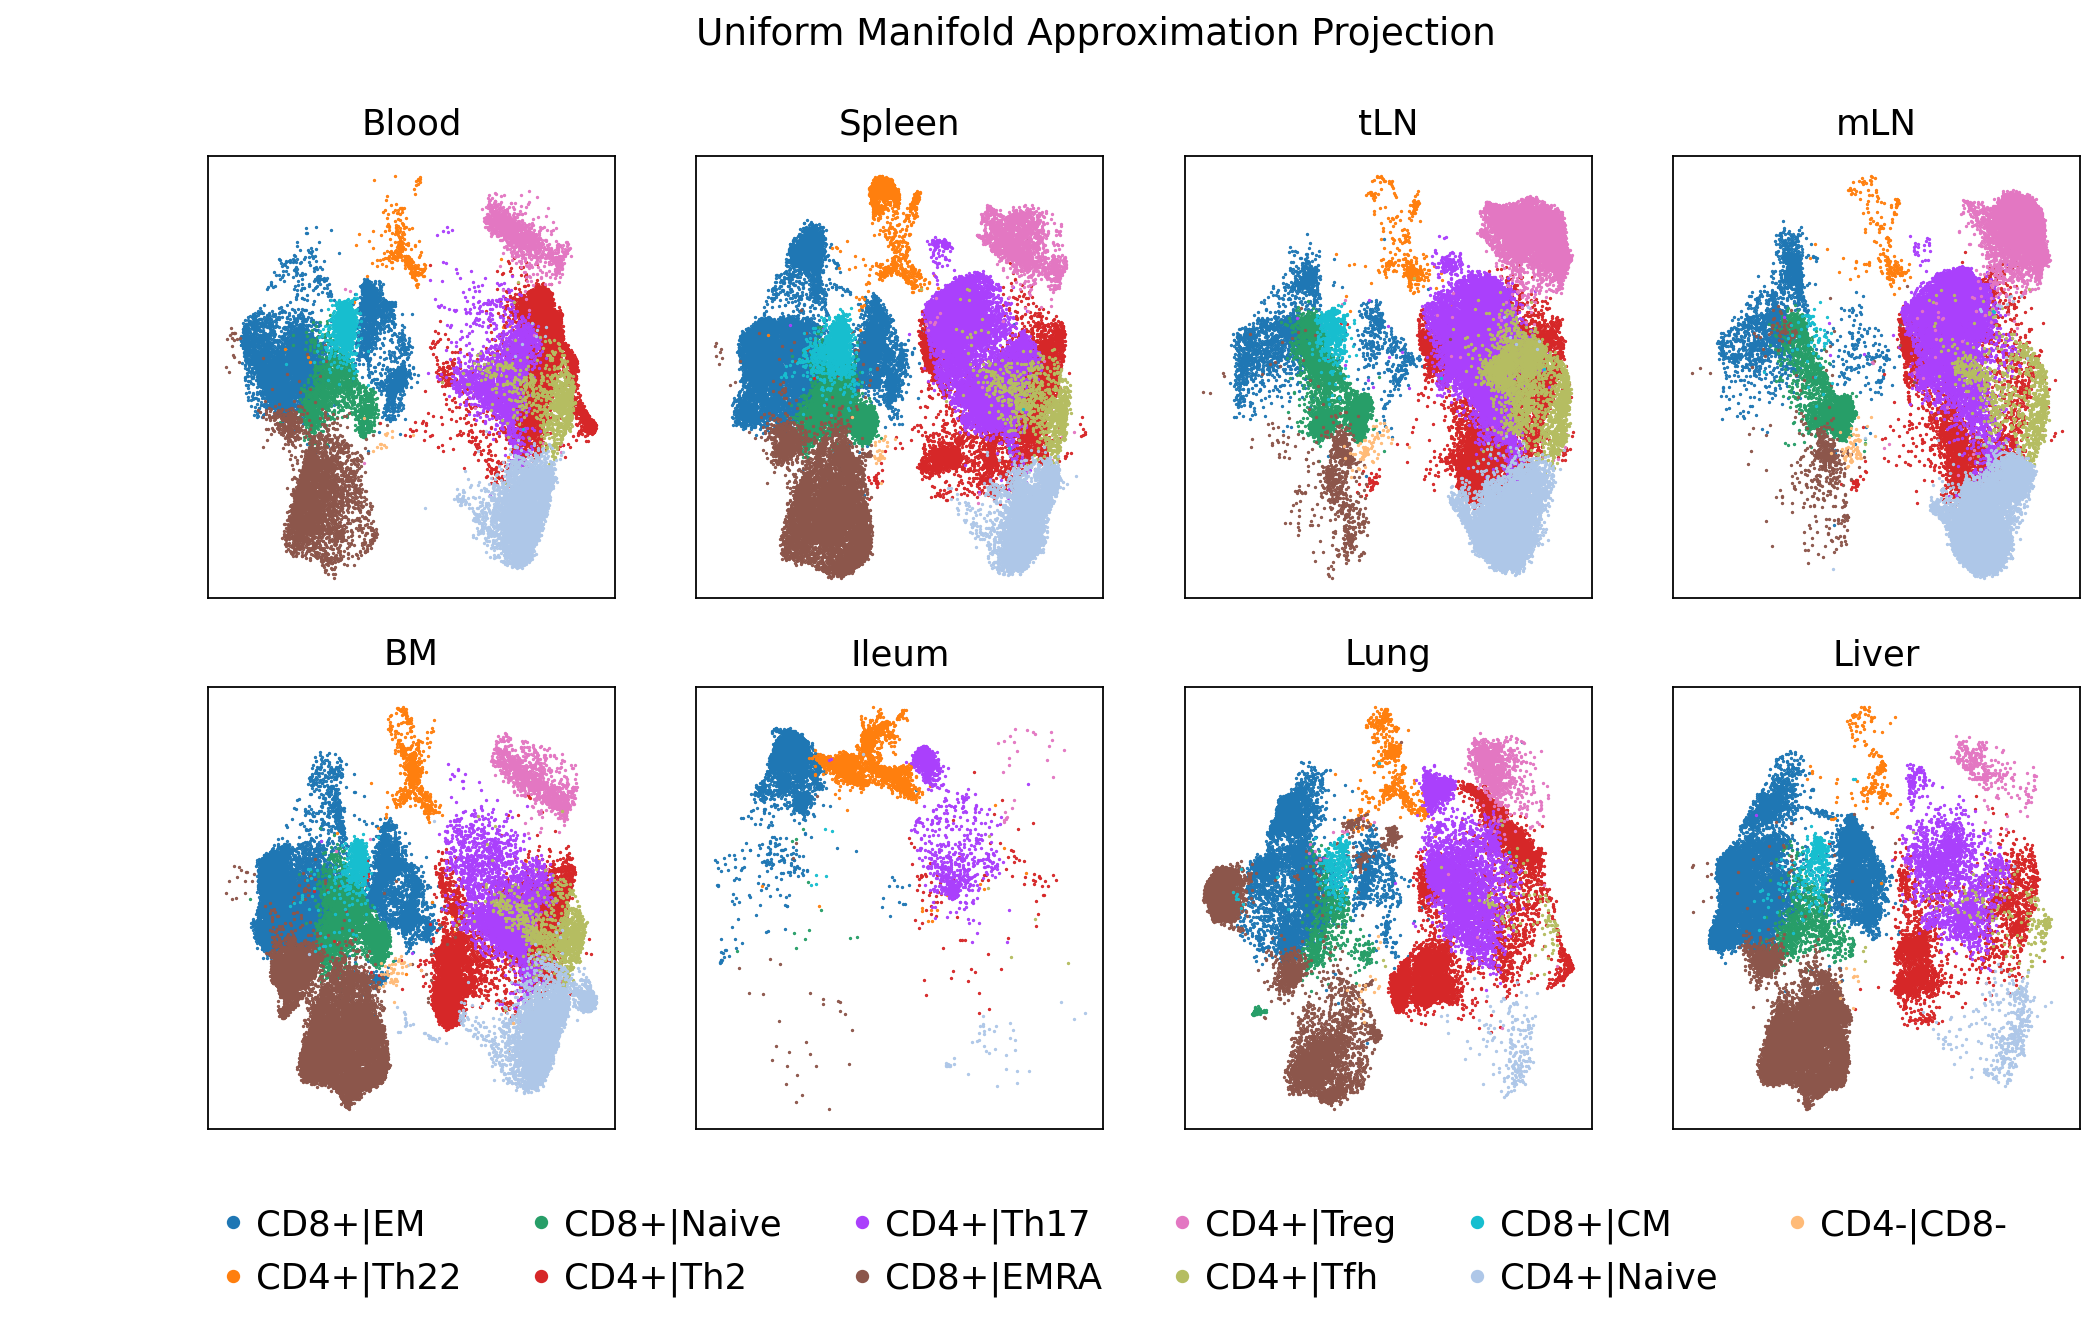

In [13]:
############################################################# dimensionally reduced per tissue and cluster
fig = figure(figsize=(15,8))
fig.suptitle('Uniform Manifold Approximation Projection',x=0.55,y=1.02)
[projection],_ = _get_data_points( annotated_dataset, 'umap', '2d', None, None, None )

for i,tissue in enumerate(tissues) :
    
    subplot(2,4,i+1)
    title(tissue,fontsize=16,y=1.02)

    lines = []
    for label in annotated_dataset.obs.label.unique() :
        mask = (annotated_dataset.obs.label==label)&(annotated_dataset.obs.tissue==tissue)
        
        points = projection[mask]
        line, = plot(points[:,0],points[:,1],'.',ms=1,label=label)

        xticks([], []); yticks([], [])
        lines += [line]
        
        
figlegend( lines, annotated_dataset.obs.label.unique(), loc = (0.1,0.01), ncol=6,
          fontsize=16, markerscale=10, frameon=False);

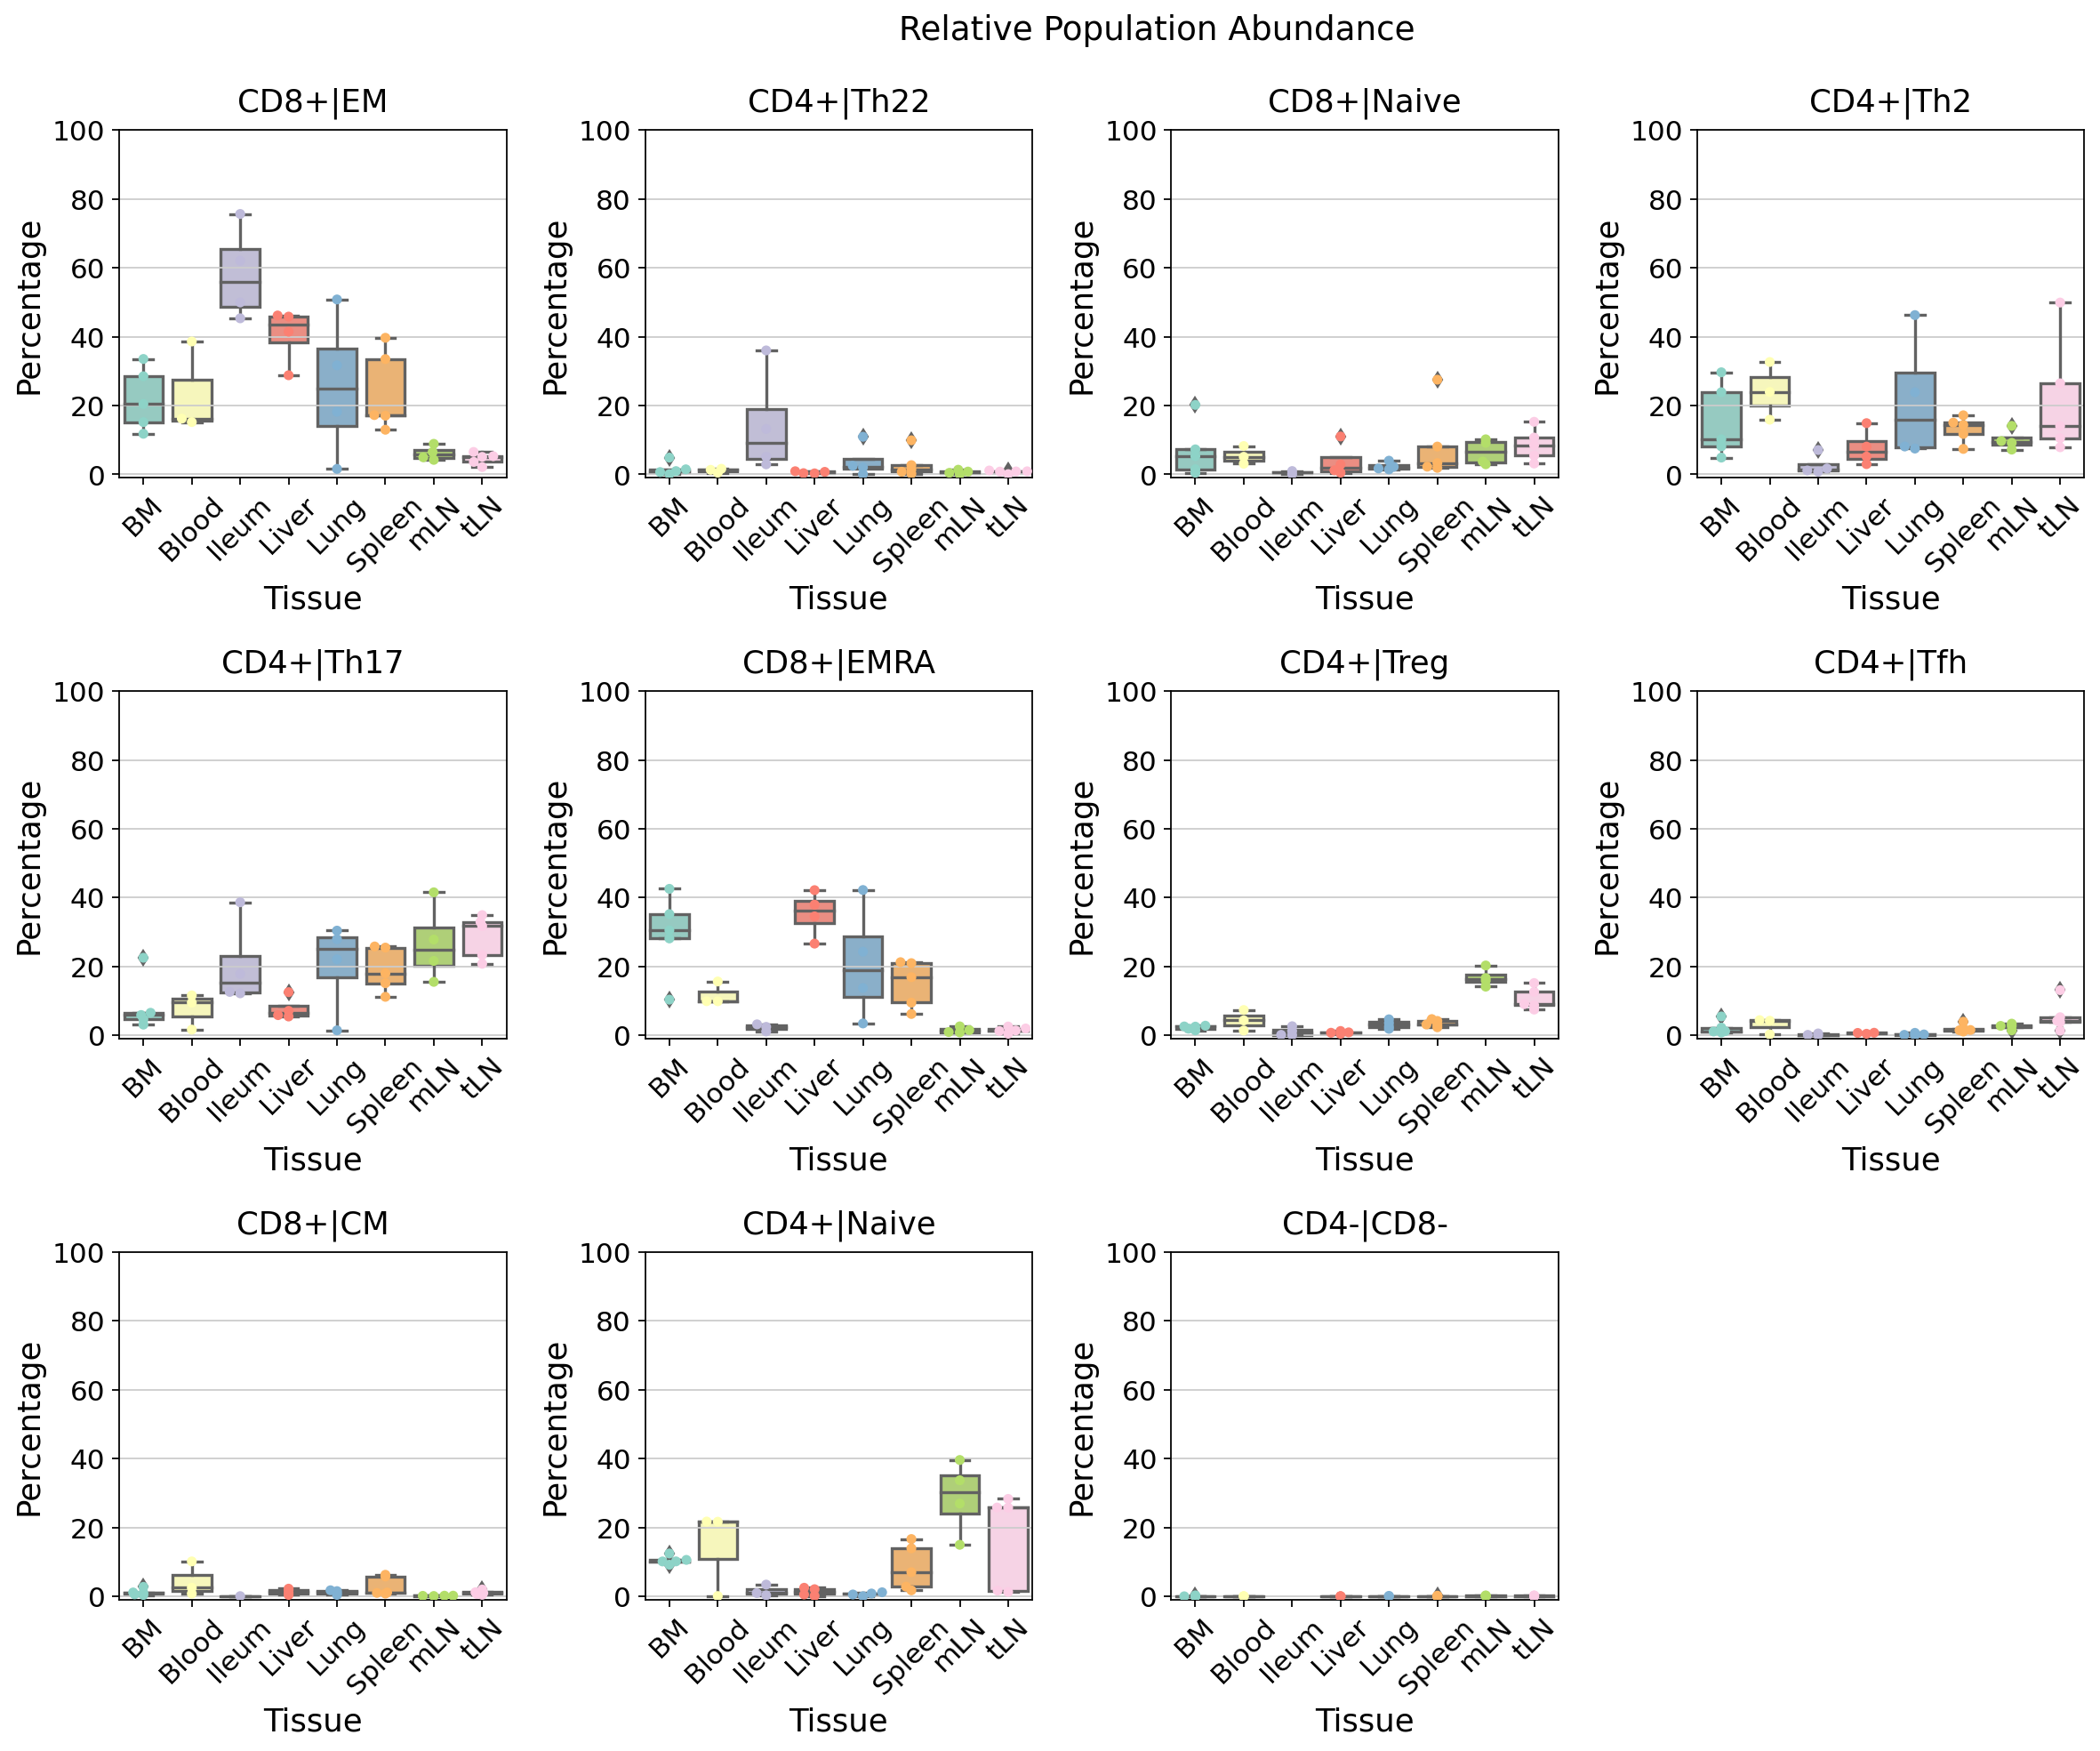

In [14]:
############################################################# relative abundance
annotated_dataset.obs['abundance'] = 1
relative_abundance = ( 100*annotated_dataset.obs.groupby(['tissue','patient','label']).count() \
/ annotated_dataset.obs.groupby(['tissue','patient']).count()[['abundance']] ).reset_index()

fig = figure(figsize=(15,15))
fig.suptitle('Relative Population Abundance',x=0.55,y=1.02)

for i,label in enumerate(labels) :
    
    subplot(4,4,i+1)
    title(label,fontsize=16,y=1.02)
    mask = relative_abundance.label == label
    
    swarmplot(x="tissue", y="abundance",
                 data=relative_abundance[mask], palette="Set3")
    ax = boxplot(x="tissue", y="abundance",
                 data=relative_abundance[mask], palette="Set3")
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
    
    xlabel('Tissue',fontsize=16)
    ylabel('Percentage',fontsize=16)
    ylim(-1,100); #yscale('log')
tight_layout()

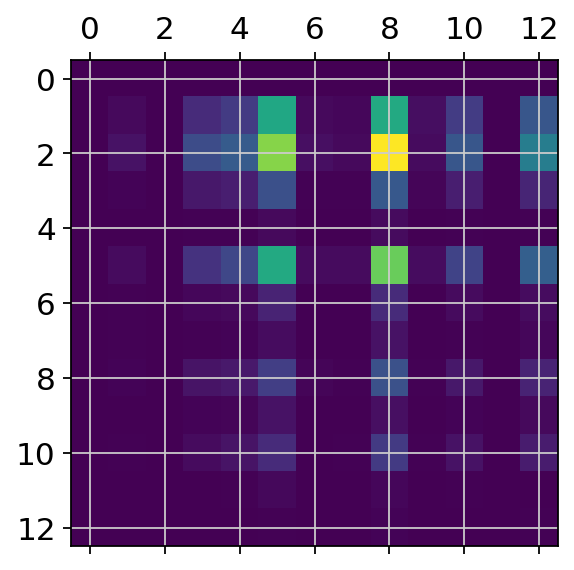

In [19]:
fig = figure()
ax = fig.add_subplot(111)
mask = annotated_dataset.obs.labels != '<NA>'
ax.matshow(confusion_matrix(annotated_dataset.obs.labels[mask],annotated_dataset.obs.label[mask],
                 labels=annotated_dataset.obs.labels.unique()))

# ax.set_xticklabels(['']+annotated_dataset.obs.labels.unique())
# ax.set_yticklabels(['']+annotated_dataset.obs.labels.unique())